In [1]:
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.sql.functions import desc
import time
from IPython import display
from collections import namedtuple
import re

In [2]:
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
# Only works for Jupyter Notebooks!
%matplotlib inline 

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

### socket stream 생성 및 데이터 전처리 과정 정의

In [29]:
# SparkSession 생성
spark = SparkSession.builder \
    .appName("SocketStreamingWordCount") \
    .getOrCreate()

In [30]:
# StreamingContext 생성
ssc = StreamingContext(spark.sparkContext, 10)

# 소켓 버퍼 크기 설정 (예: 1024 바이트)
conf = spark.sparkContext.getConf()
conf.set("spark.streaming.receiver.maxRate", "1024")

# 소켓 스트림 생성
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)

# 윈도우 설정
lines = socket_stream.window(20)

In [31]:
# # 데이터 전처리 및 단어 카운트
# def process_stream(rdd):
#     if not rdd.isEmpty():
#         # DataFrame 생성
#         word_df = rdd.toDF(["word", "count"])
#         word_df.createOrReplaceTempView("word_counts")
#         # SQL 쿼리 실행
#         top_words = spark.sql('SELECT * FROM word_counts ORDER BY count DESC LIMIT 10')

In [32]:
# 단어 카운트
(lines.flatMap(lambda line: line.split(" "))  # 공백을 기준으로 단어 분리
     .filter(lambda word: len(word) > 1)  # 한 글자 단어 제외
     .map(lambda word: (word,1)) # key, value 쌍으로 변환
     .reduceByKey(lambda a, b: a + b)  # reduce 연산
     .foreachRDD( lambda rdd: rdd.toDF(["word","count"]).sort( desc("count")) #  RDD Dataframe에 count수 기준으로 정렬해서 저장 
     .limit(10).registerTempTable("word_counts")))

In [33]:
# word_counts.foreachRDD(process_stream)

### 소켓 스트림 시작

In [34]:
ssc.start()

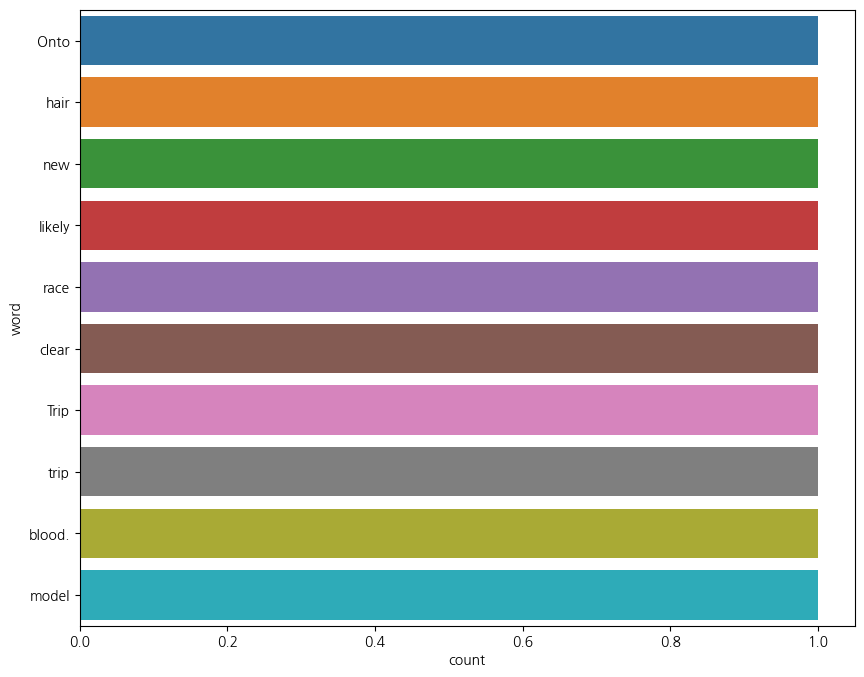

/usr/local/spark/python/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [35]:
count = 0
while count < 10:
    time.sleep(3)
    try:
        # SQL 쿼리로 상위 10개 데이터 추출
        top_10_words = spark.sql('SELECT word, count FROM word_counts')
        # 판다스 DataFrame으로 변환
        top_10_df = top_10_words.toPandas()
        
        # 시각화
        display.clear_output(wait=True)
        plt.figure(figsize=(10, 8))
        sns.barplot(x="count", y="word", data=top_10_df)
        plt.show()
        count += 1
    except:
        print("wait")
        time.sleep(3)

In [36]:
ssc.stop()